In [1]:
import os
import random
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
import pandas as pd
import csv
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from segment_anything import sam_model_registry, SamPredictor

2025-05-07 11:57:07.938239: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-07 11:57:08.666485: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/asma/thermal-cnn/lib/python3.7/site-packages/cv2/../../lib64:
2025-05-07 11:57:08.669306: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/asma/thermal-cnn/lib/python3.7/site-packages/cv2/../../l

In [2]:
# ----------------- CONFIGURATION -----------------
BASE_PATH = './data/resized_output'
FUSE_FOLDER = os.path.join(BASE_PATH, 'RMU/Fuse')
IMG_SIZE = (224, 224)
SAM_CHECKPOINT = "sam_vit_b_01ec64.pth"
DEVICE = "cpu"

In [3]:
# ----------------- CLASSIFICATION -----------------
# Label Mapping
compartment_labels = {
    ("VCB", "CB Close Door"): 0,
    ("VCB", "CB Open door"): 1,
    ("VCB", "3 Core Cable"): 2,
    ("VCB", "1 core cable"): 3,
    ("VCB", "Cable"): 5,
    ("VCB", "Busbar top"): 6,
    ("VCB", "Busbar side"): 7,
    ("VCB", "PT"): 10,
    ("RMU", "Cable Entry"): 4,
    ("RMU", "Fuse"): 8,
    ("RMU", "Cable"): 5,
    ("RMU", "PT"): 10
}

# Load and label images
image_paths, labels = [], []
for root, _, files in os.walk(BASE_PATH):
    for file in files:
        if file.endswith('_resized.png'):
            full_path = os.path.join(root, file)
            folder_name = os.path.basename(root)
            parent_folder = os.path.basename(os.path.dirname(root))
            key = (parent_folder, folder_name)
            if key in compartment_labels:
                image_paths.append(full_path)
                labels.append(compartment_labels[key])

# Prepare data
X = []
for path in image_paths:
    img = cv2.imread(path)
    img = cv2.resize(img, IMG_SIZE)
    X.append(img / 255.0)
X = np.array(X)
y = to_categorical(labels, num_classes=max(compartment_labels.values())+1)

# Train-Test Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build MobileNetV2 Model
base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
base_model.trainable = False
inputs = Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(y.shape[1], activation='softmax')(x)
model = Model(inputs, outputs)
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the Model
model.fit(X_train, y_train, epochs=25, batch_size=32, validation_data=(X_test, y_test), callbacks=[EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)])

2025-05-07 11:58:10.573281: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2025-05-07 11:58:10.573335: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: tensorbook
2025-05-07 11:58:10.573350: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: tensorbook
2025-05-07 11:58:10.573427: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 535.183.1
2025-05-07 11:58:10.573470: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 535.183.1
2025-05-07 11:58:10.573482: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 535.183.1
2025-05-07 11:58:10.573893: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Netw

Epoch 1/25
9/9 [==============================] - 6s 423ms/step - loss: 2.2841 - accuracy: 0.2421 - val_loss: 1.2480 - val_accuracy: 0.5972
Epoch 2/25
9/9 [==============================] - 3s 370ms/step - loss: 1.1595 - accuracy: 0.6632 - val_loss: 0.7326 - val_accuracy: 0.8611
Epoch 3/25
9/9 [==============================] - 3s 330ms/step - loss: 0.6922 - accuracy: 0.8000 - val_loss: 0.5296 - val_accuracy: 0.8333
Epoch 4/25
9/9 [==============================] - 3s 330ms/step - loss: 0.4493 - accuracy: 0.8947 - val_loss: 0.4726 - val_accuracy: 0.8472
Epoch 5/25
9/9 [==============================] - 3s 373ms/step - loss: 0.3207 - accuracy: 0.9088 - val_loss: 0.4214 - val_accuracy: 0.8750
Epoch 6/25
9/9 [==============================] - 3s 368ms/step - loss: 0.3046 - accuracy: 0.9158 - val_loss: 0.4137 - val_accuracy: 0.8889
Epoch 7/25
9/9 [==============================] - 3s 342ms/step - loss: 0.2361 - accuracy: 0.9193 - val_loss: 0.3897 - val_accuracy: 0.9028
Epoch 8/25
9/9 [====

In [20]:
# ----------------- SAM SEGMENTATION -----------------
# Load SAM Model
sam = sam_model_registry["vit_b"](checkpoint=SAM_CHECKPOINT).to(DEVICE)
predictor = SamPredictor(sam)

# Pick a Fuse Image
fuse_image_path = random.choice([p for p in image_paths if '/Fuse/' in p])
img = cv2.imread(fuse_image_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
predictor.set_image(img_rgb)

# Define Box for Fuse Region
input_box = np.array([[150, 100, 450, 350]])
masks, scores, logits = predictor.predict(box=input_box, multimask_output=True)
best_mask = masks[np.argmax(scores)]

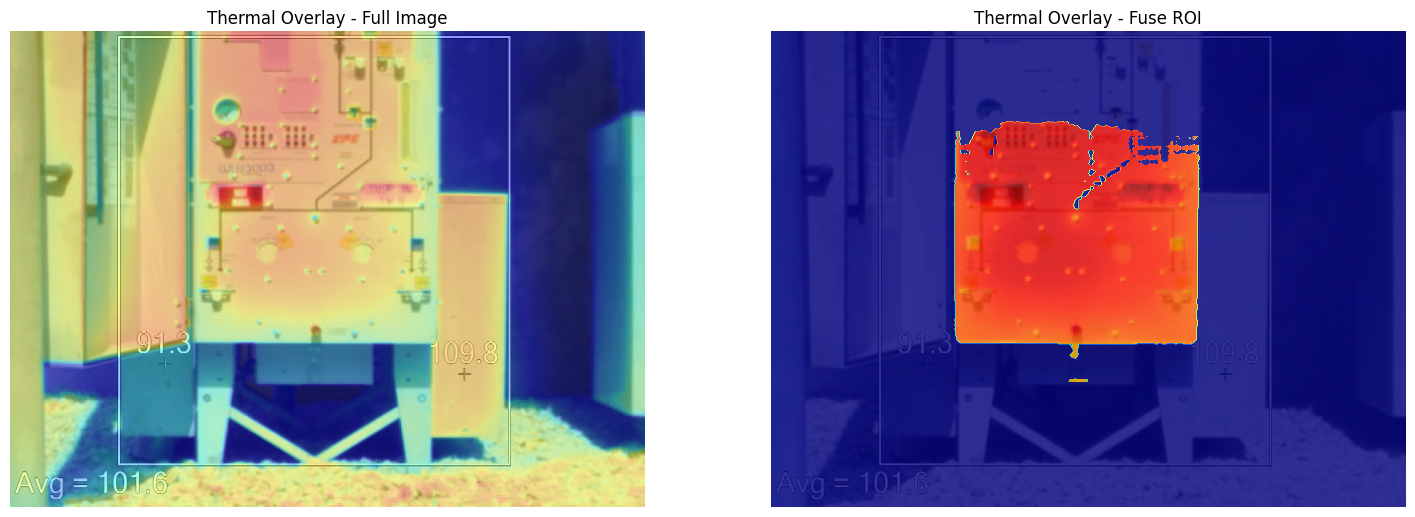

In [21]:
import csv
import numpy as np
import cv2
import matplotlib.pyplot as plt

# ----------------- THERMAL OVERLAY -----------------

def load_smartview_csv(path):
    """
    Load thermal data from SmartView CSV with proper encoding handling.
    """
    with open(path, 'r', encoding='utf-16', errors='ignore') as f:
        reader = csv.reader(f)
        rows = list(reader)

    # Extract only numeric rows (skip headers)
    thermal_matrix = []
    for row in rows:
        if row and row[0].strip().isdigit():
            try:
                thermal_matrix.append([float(val) for val in row[1:] if val.strip()])
            except ValueError:
                continue  # Ignore malformed rows

    return np.array(thermal_matrix, dtype=np.float32)

# Load Thermal Data
thermal_csv_path = fuse_image_path.replace('_resized.png', '.csv').replace('resized_output', 'organized1')
thermal = load_smartview_csv(thermal_csv_path)

# Resize thermal to match image size for precise overlay
thermal_resized = cv2.resize(thermal, (img_rgb.shape[1], img_rgb.shape[0]), interpolation=cv2.INTER_NEAREST)

# Masked Thermal ROI
thermal_masked = np.zeros_like(thermal_resized)
thermal_masked[best_mask] = thermal_resized[best_mask]

# Plot the full image with thermal overlay and the isolated ROI
plt.figure(figsize=(18, 8))

# Full Image with Thermal Overlay
plt.subplot(1, 2, 1)
plt.imshow(img_rgb)
plt.imshow(thermal_resized, cmap='jet', alpha=0.4)
plt.title("Thermal Overlay - Full Image")
plt.axis('off')

# Isolated Fuse ROI with Thermal Overlay
plt.subplot(1, 2, 2)
plt.imshow(img_rgb)
plt.imshow(thermal_masked, cmap='jet', alpha=0.8)
plt.title("Thermal Overlay - Fuse ROI")
plt.axis('off')

plt.show()

In [22]:
# ----------------- DELTA T CALCULATION -----------------
max_temp = np.max(thermal_masked)
min_temp = np.min(thermal_masked[thermal_masked > 0])
delta_t = max_temp - min_temp
status = "DEFECT" if delta_t > 33.8 else "NORMAL"

print(f"Max Temp: {max_temp:.2f}°F")
print(f"Min Temp: {min_temp:.2f}°F")
print(f"Delta T: {delta_t:.2f}°F")
print(f"Status: {status}")

Max Temp: 122.90°F
Min Temp: 81.20°F
Delta T: 41.70°F
Status: DEFECT
